<a href="https://colab.research.google.com/github/Padmashree02/Object_Detection-Yolo_V4/blob/main/Main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imported required libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

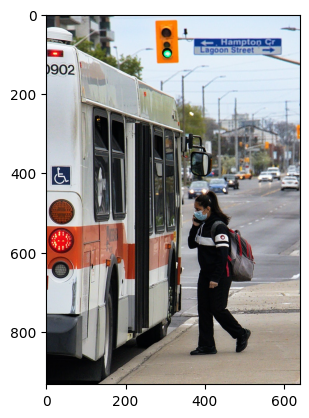

In [2]:
#Load the image for the input data purpose
image=cv2.imread('/content/Input_image.jpg')

#Display the image by swaping BGR to RGB format
plt.imshow(image[:,:,::-1])

In [3]:
#Load the model
model_file = '/content/yolov4.weights'   #binary file - trained weights
config_file = '/content/yolov4.cfg'      #text file- network configuration
class_file = '/content/coco.names'       #Dataset

In [4]:
#Extract the classes from class file
with open (class_file,'rt') as f:
  classes=f.read().rstrip('\n').split('\n')
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [5]:
#read the model or neural network
model=cv2.dnn.readNetFromDarknet(config_file,model_file)

In [6]:
#Extracting all output layers from Yolo V4 model
def getOutputsNames(model):
    layersNames = model.getLayerNames()
    for i in model.getUnconnectedOutLayers():
      layer=layersNames[i - 1]
    return layer

In [7]:
#Define the parameters for the YOLO V4 model

#Thresholds
object_threshold=0.5
confidence_threshold=0.5  #removes those bounding boxes which has less confidence in detecting
nms_threshold=0.4         #removes those bounding boxes that are overlapped

#Image's shape based on YOLO V4 model
img_w=608
img_h=608

In [8]:
#Define the detection function (detects the object)

def detection(img,model):
  #Default values
  mean=(0,0,0)

  #convert the image into network understanding format (blob)
  blob=cv2.dnn.blobFromImage(img,1/255,(img_w,img_w),mean,1,crop=False)

  #Set the input data to the DenseNet model
  model.setInput(blob)

  #Pass the blob Forward to the DenseNet model
  detected_obj=model.forward(getOutputsNames(model))
  return detected_obj

In [9]:
#Define the function that display the detected class on each detected object

def draw_text(im, text, x, y):

    #Default Text values
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1

    #Get text size
    textSize = cv2.getTextSize(text, fontface, font_scale, thickness)  #returns in tuple
    dim = textSize[0]        # width,height
    baseline = textSize[1]

    #Use text size to create a black rectangle. (top left and bottom right)
    cv2.rectangle(im, (x, y), (x + dim[0], y + dim[1] + baseline), (0, 0, 0), cv2.FILLED);

    #Display text inside the rectangle
    cv2.putText(im, text, (x, y + dim[1]), fontface, font_scale, (0, 255, 255), thickness, cv2.LINE_AA)

In [10]:
#Object detection process

def draw_object(img_test,objects_detected):

  valid_detections=0
  classIds=[]
  confidences=[]
  boxes=[]

  #define the height and width wrt image's dimension
  image_height=image.shape[0]
  image_width=image.shape[1]

  #process each detection
  for obj_detection in objects_detected:

    if obj_detection[4]>object_threshold:

      #Extract all scores detected wrt each class
      score=obj_detection[5:]

      #Extract the classID
      classID=np.argmax(score)

      #Confidence score
      confidence=score[classID]

      #Checking whether the the object has been detected good or bad
      if confidence>confidence_threshold:

        #convert the normalized coordinates to origional coordinates wrt defined image's shape
        center_x=int(obj_detection[0]*image_width)
        center_y=int(obj_detection[1]*image_height)
        Width=int(obj_detection[2]*image_width)
        Height=int(obj_detection[3]*image_height)

        left=int(center_x-Width/2)
        top=int(center_y-Height/2)

        #Append all values in respective list
        classIds.append(classID)
        confidences.append(confidence)
        boxes.append([left,top,Width,Height])

  #Perform Non Maximum Suppression on each detected object
  indices=cv2.dnn.NMSBoxes(boxes,confidences,confidence_threshold,nms_threshold)
  for i in indices:

    #Count the valid detections
    valid_detections=valid_detections+1

    #Extract each element from bounding box list
    box=boxes[i]
    left=box[0]
    top=box[1]
    width=box[2]
    height=box[3]

    #Draw the bounding box to display the detected object
    cv2.rectangle(image,(left,top),(left+width,top+height),(255,255,255),2)

    #Display the class name
    label='{}:{:.2f}'.format(classes[classIds[i]],confidences[i])
    draw_text(image,label,left,top)

  return image,valid_detections

Number of good object detections = 4
Inference time: 5289.31 ms


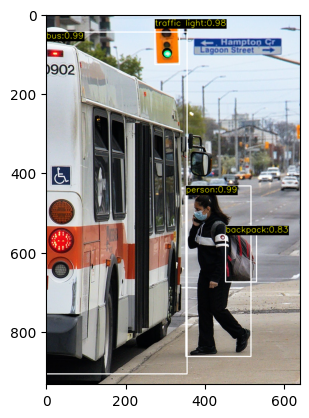

In [11]:
#Calling all the defined fucntions

#Detects the objects on the input image
objects_detected=detection(image,model)

#Performs object detection
img_result,valid_detections=draw_object(image.copy(),objects_detected)

#Display the face detection result of the image
plt.imshow(img_result[:,:,::-1])
print("Number of good object detections =",valid_detections)

#Computes how long does model executes Object detection on the image
t, _ = model.getPerfProfile()
time = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
print(time)

In [12]:
#Save the output image
cv2.imwrite("Object_detection.jpg",img_result)

True